In [ ]:
#import libraries
import torch
import torch.nn as nn  
import scipy
import numpy as np
import matplotlib.pyplot as plt
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

# Set device: GPU가 사용 가능하면 GPU를, 아니면 CPU를 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generating Data (m = sensor points, n = # of random fields generated by the GRF)
m = 100
n = 110

x = np.linspace(0, 1, m)

seed = MasterRNG(20250211)
def one_function(x):
    model = Gaussian(dim=1, var=3, len_scale=0.2)
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

U = np.zeros((m, n))
for i in range(n):
    U[:, i] = one_function(x)

def integrate_one_function(f):
    result = np.zeros_like(f)
    result[0] = 0
    for i in range(1, len(f)):
        result[i] = integrate.simpson(f[:i+1], x=x[:i+1])  # Numerical integration using Simpson's rule
    return result

S = np.zeros((m, n))
for i in range(n):
    S[:, i] = integrate_one_function(U[:, i])

# example data ( integration result for specific x value to function)
i = 10
j = 5
u = U[:, i]
x_ = x[j]
s = S[j, i]

u = torch.tensor(u, dtype=torch.float32).unsqueeze(1)
x_ = torch.tensor([x_], dtype=torch.float32).unsqueeze(1)
s = torch.tensor([s], dtype=torch.float32).unsqueeze(1)

U_train = torch.tensor(U, dtype=torch.float32)
S_train = torch.tensor(S, dtype=torch.float32)
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

def integrate_dataset(m=m, n=n, x=x, U=U, S=S):
    us = np.zeros((m * n, m))
    xs = np.zeros((m * n, 1))
    ss = np.zeros((m * n, 1))
    for i in range(n):
        for j in range(m):
            us[i * m + j, :] = U[:, i]
            xs[i * m + j, :] = x[j]
            ss[i * m + j, :] = S[j, i]
    return us, xs, ss

us, xs, ss = integrate_dataset()

def batch_dataset(batch_size, m=m, n=n, x=x, U=U, S=S, ratio=0.8):
    us, xs, ss = integrate_dataset(m, n, x, U, S)
    train_size = int(len(us) * ratio)
    us_train = us[:train_size]
    xs_train = xs[:train_size]
    ss_train = ss[:train_size]

    us_test = us[train_size:]
    xs_test = xs[train_size:]
    ss_test = ss[train_size:]

    us_train = torch.tensor(us_train, dtype=torch.float32)
    xs_train = torch.tensor(xs_train, dtype=torch.float32)
    ss_train = torch.tensor(ss_train, dtype=torch.float32)

    train_dataset = torch.utils.data.TensorDataset(us_train, xs_train, ss_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    us_test = torch.tensor(us_test, dtype=torch.float32)
    xs_test = torch.tensor(xs_test, dtype=torch.float32)
    ss_test = torch.tensor(ss_test, dtype=torch.float32)

    test_dataset = torch.utils.data.TensorDataset(us_test, xs_test, ss_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    return train_dataloader, test_dataloader

# datasets
train_data, test_data = batch_dataset(40, ratio=0.9)

class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1=1, in2=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.neurons = neurons
        self.in1 = in1
        self.in2 = in2
        self.output_neurons = output_neurons
        self.b = torch.nn.parameter.Parameter(torch.tensor(0.0))
        self.b1 = self.branch()
        self.b2 = self.trunk()

    def branch(self):
        b1 = nn.Sequential(
            nn.Linear(self.in1, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return b1
    
    def trunk(self):
        b2 = nn.Sequential(
            nn.Linear(self.in2, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return b2
    
    def forward(self, x1, x2):
        x1 = self.b1(x1)
        x2 = self.b2(x2)
        x = torch.einsum("bi, bi -> b", x1, x2)
        x = torch.unsqueeze(x, 1)
        x += self.b
        return x

In [2]:
print("Using device:", device)
# 모델 생성 및 GPU로 이동
model = DeepONet(neurons=40, in1=m, in2=1).to(device)

def loss(y_pred, y):
    return torch.mean((y_pred - y)**2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
epochs = 300

for epoch in range(epochs):
    model.train()
    l_total = 0
    for u_batch, x_batch, s_batch in train_data:
        u_batch = u_batch.to(device)
        x_batch = x_batch.to(device)
        s_batch = s_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(u_batch, x_batch)
        l = loss(y_pred, s_batch)
        l.backward()
        optimizer.step()
        l_total += l.item()
        
    l_total = l_total / len(train_data)
    train_losses.append(l_total)
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {l_total:.6f}")
    if l_total < 1e-5:
        break

Using device: cuda
Epoch 0, Loss: 0.074867
Epoch 1, Loss: 0.013272
Epoch 2, Loss: 0.008810
Epoch 3, Loss: 0.006645
Epoch 4, Loss: 0.004909
Epoch 5, Loss: 0.004348
Epoch 6, Loss: 0.004002
Epoch 7, Loss: 0.004093
Epoch 8, Loss: 0.002898
Epoch 9, Loss: 0.001520
Epoch 10, Loss: 0.001517
Epoch 11, Loss: 0.002051
Epoch 12, Loss: 0.001243
Epoch 13, Loss: 0.001274
Epoch 14, Loss: 0.001161
Epoch 15, Loss: 0.001353
Epoch 16, Loss: 0.001347
Epoch 17, Loss: 0.001362
Epoch 18, Loss: 0.001245
Epoch 19, Loss: 0.001323
Epoch 20, Loss: 0.001327
Epoch 21, Loss: 0.001167
Epoch 22, Loss: 0.001549
Epoch 23, Loss: 0.001062
Epoch 24, Loss: 0.001247
Epoch 25, Loss: 0.001151
Epoch 26, Loss: 0.001273
Epoch 27, Loss: 0.001084
Epoch 28, Loss: 0.001216
Epoch 29, Loss: 0.001045
Epoch 30, Loss: 0.001300
Epoch 31, Loss: 0.000957
Epoch 32, Loss: 0.001095
Epoch 33, Loss: 0.000888
Epoch 34, Loss: 0.000667
Epoch 35, Loss: 0.000861
Epoch 36, Loss: 0.000829
Epoch 37, Loss: 0.000841
Epoch 38, Loss: 0.000768
Epoch 39, Loss: 

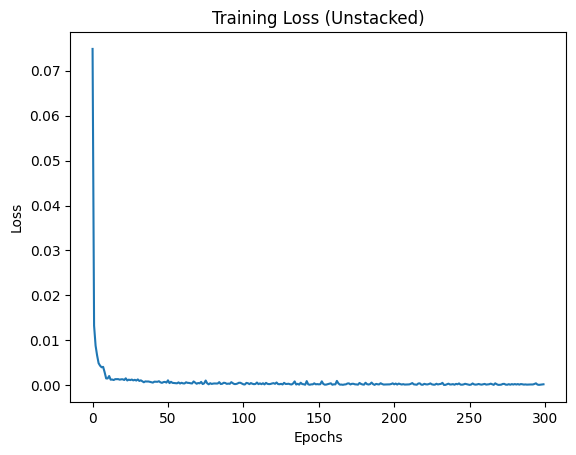

In [3]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss (Unstacked)")
plt.show()

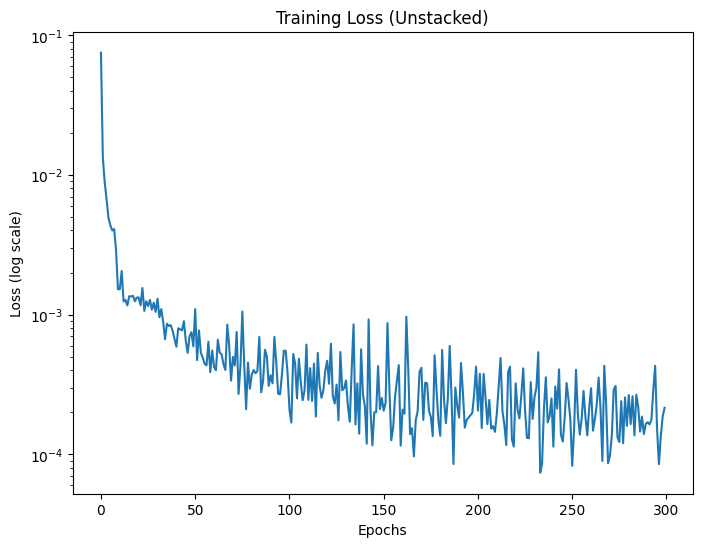

In [4]:
plt.figure(figsize=(8,6))
plt.plot(train_losses)
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss (Unstacked)")
plt.show()

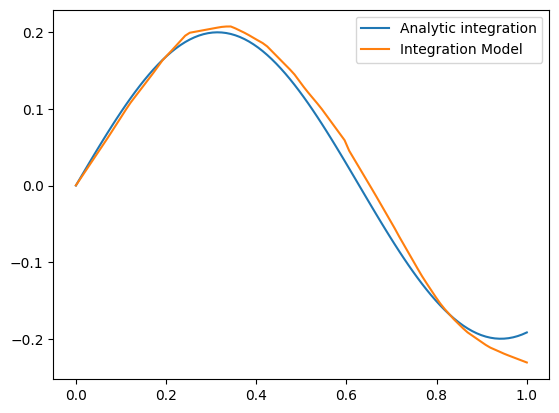

In [5]:
my_func = lambda x: np.cos(5*x)
inter = lambda x: 1/5*np.sin(5*x)
u_t = my_func(x)
s_t = inter(x)

model = model.to(device)
model.eval()
u_t_ = torch.tensor(u_t, dtype= torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype = torch.float32).unsqueeze(1).to(device)
p = model(u_t_, x_)
p = p.detach().cpu().numpy()

plt.plot(x, s_t, label = "Analytic integration")
plt.plot(x, p, label = "Integration Model")
plt.legend();

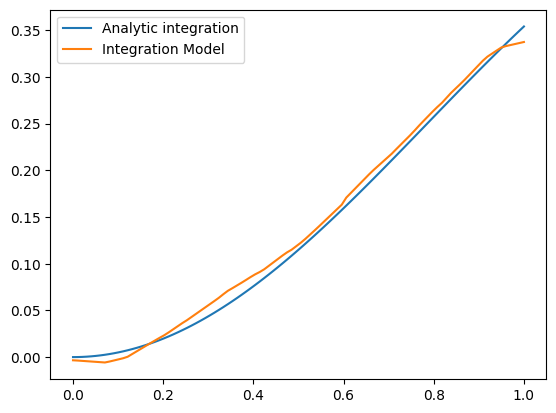

In [6]:
my_func = lambda x: np.cos(x)*np.sin(x)
inter = lambda x: 1/2*(np.sin(x))**2
u_t = my_func(x)
s_t = inter(x)

model = model.to(device)
model.eval()
u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
p = model(u_t_, x_)
p = p.detach().cpu().numpy()

plt.plot(x, s_t, label = "Analytic integration")
plt.plot(x, p, label = "Integration Model")
plt.legend();